    +------------+     +---------------+     +-----------+
    | user_data  |     | post_text_df  |     | feed_data |
    +------------+     +---------------+     +-----------+
    | age        |     | id            |     | timestamp |
    | city       |     | text          |     | user_id   |
    | country    |     | topic         |     | post_id   |
    | exp_group  |     +---------------+     | action    |
    | gender     |           7,023           | target    |
    | id         |                           +-----------+
    | os         |                             76,892,800
    | source     |
    +------------+
        163,205 

# Импорт данных

In [40]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from catboost import Pool, CatBoostClassifier
import numpy as np
import re
from string import punctuation
from sklearn.metrics import roc_curve, auc

# Загрузка данных

In [41]:
engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')

In [42]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-07 07:53:57,158185,412,view,0,0,19,Russia,Moscow,1,iOS,organic,Slowdown hits US factory growth\n\nUS industri...,business
1,2021-11-07 07:55:39,158185,6992,view,0,0,19,Russia,Moscow,1,iOS,organic,House of Dracula was made towards the end of U...,movie
2,2021-11-07 07:58:08,158185,3950,view,0,0,19,Russia,Moscow,1,iOS,organic,an assault on the Citizens of the United State...,covid
3,2021-11-07 08:00:18,158185,2843,view,0,0,19,Russia,Moscow,1,iOS,organic,"Changes in monsoon patterns, periods of drough...",covid
4,2021-11-07 08:01:00,158185,2907,view,0,0,19,Russia,Moscow,1,iOS,organic,#TheGreatCoronavirusFraudOf2020: I-Team: Death...,covid


# Обработка временных меток

In [43]:
# Преобразование формата временных меток в объект datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Извлечение признаков из временных меток
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Расчет времени с момента последнего действия для каждого пользователя
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)

# Удаление столбца временных меток
data = data.drop('timestamp', axis=1)

In [44]:
data.head()

,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
653,30162,5365,view,0,1,14,Russia,Omsk,4,iOS,ads,This is on my TV right now... but only long en...,movie,6,11,0.0
654,30162,3725,view,0,1,14,Russia,Omsk,4,iOS,ads,@SundayTimesZA Exactly. When I heard Russia de...,covid,6,11,157.0
655,30162,1116,view,0,1,14,Russia,Omsk,4,iOS,ads,Blairs hope for Blunkett return\n\nThe events ...,politics,6,11,59.0
656,30162,1204,view,0,1,14,Russia,Omsk,4,iOS,ads,Voters reject EU by two to one\n\nBritish vote...,politics,6,11,50.0
657,30162,6557,view,0,1,14,Russia,Omsk,4,iOS,ads,The fact that I did not like the music is a ve...,movie,6,11,145.0


In [45]:
import pandas as pd

# Выбираем только категориальные столбцы
categorical_columns = data.select_dtypes(include='object').columns

# Анализируем каждый категориальный столбец
for col in categorical_columns:
    print(f"Столбец: {col}")
    
    unique_values = data[col].nunique()
    print(f"Количество уникальных значений: {unique_values}")
    
    # Выводим процентное распределение категорий
    value_counts = data[col].value_counts(normalize=True) * 100
    print(f"Распределение категорий (Топ-10):")
    print(value_counts.head(10))
    
    print("\n")
    
    # Предлагаем метод кодирования на основе количества уникальных значений
    if unique_values <= 10:
        print(f"Рекомендуемый метод кодирования для столбца {col}: One-hot encoding")
    elif unique_values > 10 and unique_values <= 50:
        print(f"Рекомендуемый метод кодирования для столбца {col}: Label encoding")
    else:
        print(f"Рекомендуемый метод кодирования для столбца {col}: Target encoding (с учетом сглаживания)")
    
    print("\n---\n")


Столбец: action
Количество уникальных значений: 2
Распределение категорий (Топ-10):
action
view    89.623
like    10.377
Name: proportion, dtype: float64


Рекомендуемый метод кодирования для столбца action: One-hot encoding

---

Столбец: country
Количество уникальных значений: 7
Распределение категорий (Топ-10):
country
Russia        85.375
Belarus        4.221
Kazakhstan     4.139
Ukraine        3.100
Azerbaijan     2.302
Turkey         0.646
Finland        0.217
Name: proportion, dtype: float64


Рекомендуемый метод кодирования для столбца country: One-hot encoding

---

Столбец: city
Количество уникальных значений: 148
Распределение категорий (Топ-10):
city
Moscow              10.043
Saint Petersburg     5.827
Krasnoyarsk          2.272
Novokuznetsk         2.253
Yekaterinburg        2.185
Minsk                2.118
Ufa                  1.545
Qaraghandy           1.536
Novosibirsk          1.390
Staryy Oskol         1.353
Name: proportion, dtype: float64


Рекомендуемый метод коди

In [46]:
categorical_columns

Index(['action', 'country', 'city', 'os', 'source', 'text', 'topic'], dtype='object')

# Кодирование категориальных признаков

In [23]:
# Используем label encoder для кодирования категориальных признаков
le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()
le_topic = LabelEncoder()

# Label encoding для 'gender', 'os' и 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])
data['topic']

In [24]:
data.head()

,user_id,post_id,action,target,gender,age,exp_group,os,source,text,...,city_Yeysk,city_Zavyalovo,city_Zhukovskiy,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
89019,10880,6122,1,0,1,29,0,1,0,"Of course, how could he. He obviously co-opted...",...,False,False,False,False,False,False,True,False,False,False
89020,10880,4865,1,0,1,29,0,1,0,Alter Egos do not come funnier than the creati...,...,False,False,False,False,False,False,True,False,False,False
89021,10880,6947,1,0,1,29,0,1,0,Dane tries to hard and is to extreme with all ...,...,False,False,False,False,False,False,True,False,False,False
89022,10880,1233,1,0,1,29,0,1,0,Blunkett sorry over murder plan\n\nDavid Blunk...,...,False,False,False,False,False,False,False,True,False,False
89023,10880,1706,1,0,1,29,0,1,0,England to launch ref protest\n\nEngland will ...,...,False,False,False,False,False,False,False,False,True,False


In [25]:
data.head()

,user_id,post_id,action,target,gender,age,exp_group,os,source,text,...,city_Yeysk,city_Zavyalovo,city_Zhukovskiy,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
89019,10880,6122,1,0,1,29,0,1,0,"Of course, how could he. He obviously co-opted...",...,False,False,False,False,False,False,True,False,False,False
89020,10880,4865,1,0,1,29,0,1,0,Alter Egos do not come funnier than the creati...,...,False,False,False,False,False,False,True,False,False,False
89021,10880,6947,1,0,1,29,0,1,0,Dane tries to hard and is to extreme with all ...,...,False,False,False,False,False,False,True,False,False,False
89022,10880,1233,1,0,1,29,0,1,0,Blunkett sorry over murder plan\n\nDavid Blunk...,...,False,False,False,False,False,False,False,True,False,False
89023,10880,1706,1,0,1,29,0,1,0,England to launch ref protest\n\nEngland will ...,...,False,False,False,False,False,False,False,False,True,False


# Отбор признаков

In [26]:
data = data.drop(['text'], axis=1)

In [27]:
X = data.drop(['target', 'action'], axis=1)
y = data['target']

# Вычисление взаимной информации между каждым признаком и целевой переменной
mi_scores = mutual_info_classif(X, y, random_state=42)

# Создание DataFrame с именами признаков и соответствующими им оценками MI
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Сортировка DataFrame по оценкам MI в порядке убывания
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# При необходимости выберите k лучших признаков с помощью SelectKBest
selector = SelectKBest(mutual_info_classif, k=50)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)

Top k features based on mutual information:
Index(['user_id', 'gender', 'age', 'exp_group', 'os', 'day_of_week',
       'hour_of_day', 'time_since_last_action', 'country_Russia',
       'country_Ukraine', 'city_Aqtöbe', 'city_Armavir', 'city_Chelyabinsk',
       'city_Gorno-Altaysk', 'city_Gubkin', 'city_Horishni Plavni',
       'city_Izhevsk', 'city_Kansk', 'city_Kemerovo', 'city_Krasnodar',
       'city_Krasnotur’insk', 'city_Kyiv', 'city_Lipetsk', 'city_Makhachkala',
       'city_Moscow', 'city_Neftekamsk', 'city_Nicosia',
       'city_Nizhniy Novgorod', 'city_Novovolynsk', 'city_Pavlohrad',
       'city_Saint Petersburg', 'city_Sochi', 'city_Sokol', 'city_Sterlitamak',
       'city_Syzran', 'city_Tver', 'city_Ufa', 'city_Ulan-Ude',
       'city_Ulyanovsk', 'city_Vizinga', 'city_Volzhskiy', 'city_Voronezh',
       'city_Yalta', 'city_Yelets', 'city_Yeysk', 'city_Zhukovskiy',
       'topic_business', 'topic_covid', 'topic_movie', 'topic_sport'],
      dtype='object')


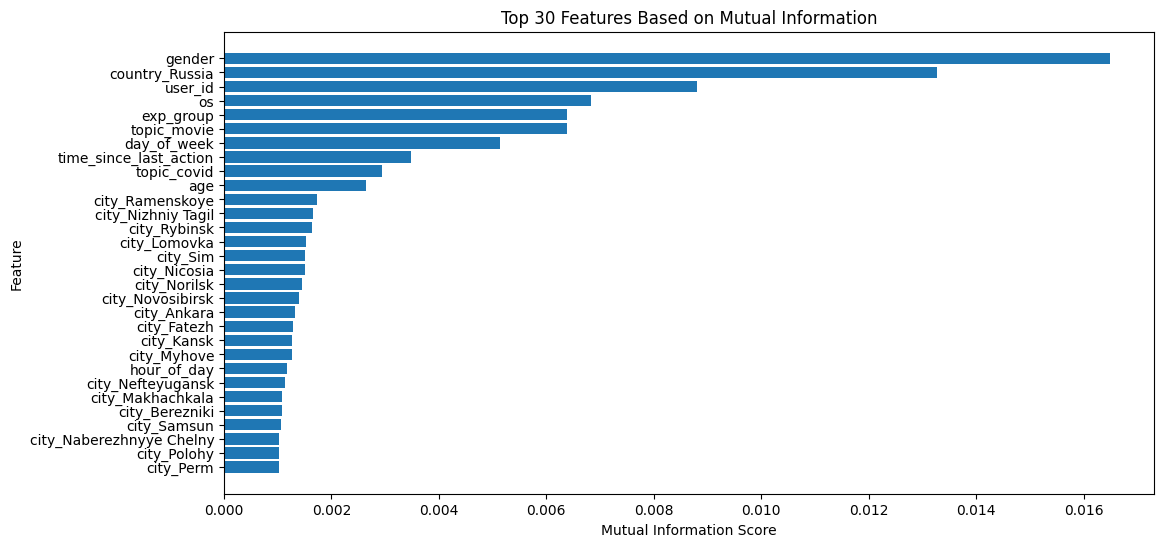

In [28]:
# Установка количества признаков для отображения
top_k = 30

# Получение топ-k признаков
top_k_features = mi_scores_df.head(top_k)

# Визуализация топ-k признаков
plt.figure(figsize=(12, 6))
plt.barh(top_k_features['feature'], top_k_features['mi_score'], align='center')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top {} Features Based on Mutual Information'.format(top_k))
plt.gca().invert_yaxis()
plt.show() 

# Обучение модели CatBoost

## Train-test split

Этот код формирует выборку данных с заданными признаками, выбирая топ-k признаков с использованием взаимной информации, без утечки данных, временной метки, 'action' и 'text'. Затем данные разбиваются на обучающую и тестовую выборки с заданным отношением размеров, и рандомным состоянием генератора псевдослучайных чисел.

In [29]:
# Выборка данных с выбранными функциями, топ-k функций с взаимной информацией, без утечки данных, временной метки, 'action' и 'text'
X = data[selected_features]

# Выборка целевой переменной
y = data['target']

# Убедиться, что каждый столбец уникален
X = X.loc[:,~X.columns.duplicated()]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Мы работаем с данными, где каждый объект имеет некоторый идентификатор пользователя (user_id). Модель должна быть обучена на этих данных, учитывая группы объектов с одинаковыми идентификаторами пользователей. Прежде всего, мы создаем столбец group_id, который представляет собой уникальный идентификатор группы для каждого пользователя.

Затем мы сортируем обучающие и тестовые наборы данных по group_id, что позволяет нам группировать объекты с одинаковыми идентификаторами пользователей вместе. Это делается для обучения и тестирования модели в соответствии с группами пользователей.

Мы создаем объекты Pool для обучающей и тестовой выборок с информацией о группах пользователей. Объект Pool является специальной структурой данных, используемой библиотекой CatBoost для эффективной работы с данными. В этом случае мы передаем group_id для каждого объекта, чтобы CatBoost мог использовать эту информацию во время обучения и тестирования модели.

Далее мы обучаем классификатор CatBoost с использованием метрики PrecisionAt:top=5. Эта метрика оценивает качество предсказания топ-5 классов. Модель обучается на train_pool и валидируется на test_pool. Важно отметить, что в этой задаче мы используем группированные данные, поэтому CatBoost будет учитывать идентификаторы групп при обучении и оценке.

Данные, которые поступают в модель, представляют собой обучающие и тестовые наборы данных с удаленным столбцом user_id. Вместо этого, информация о группах пользователей передается через объекты Pool.

После обучения модели мы получаем модель, которая оптимизирована для метрики PrecisionAt:top=5. Это означает, что модель будет хорошо работать в задаче предсказания 5 наиболее вероятных классов для каждого объекта, учитывая идентификаторы групп пользователей.

# Целевой кодировщик с предварительным сглаживанием.
Источник: https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69

In [32]:
object_cols = list(data).select_dtypes(include='object').columns

AttributeError: 'list' object has no attribute 'select_dtypes'

In [ ]:


def mean_encoding_smooth(data, col, target='target'):

    stats = data['target'].groupby(data[col]).agg(['count', 'mean'])

    
    
    smoothing_factor = 1.0 # Значение f в уравнении сглаживающего фактора
    min_samples_leaf = 1 # Значение k в уравнении сглаживающего фактора
    prior = data['target'].mean()
    smoove = 1 / (1 + np.exp(-(stats['count'] - min_samples_leaf) / smoothing_factor))
    smoothing = prior * (1 - smoove) + stats['mean'] * smoove
    encoded = pd.Series(smoothing, name = f'{col}_encoded_complete')

    return encoded

for col in object_cols:
    encoded = mean_encoding_smooth(X_train, col, target='target')

    X_train[col] = X_train[col].map(encoded)
    X_test[col] = X_test[col].map(encoded)


## Обучение модели на Precision@5 

Мы создаем группы данных на основе идентификатора пользователя 'user_id', чтобы иметь возможность проводить обучение с учетом группировки данных. Затем мы сортируем данные по группам и создаем объекты Pool для обучения и тестирования с колонкой 'group_id', которые затем будут использоваться для обучения модели и оценки ее производительности.

In [13]:
# Создание ID группы на основе столбца 'user_id'
unique_user_ids = X_train['user_id'].unique()
group_id_dict = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
X_train['group_id'] = X_train['user_id'].map(group_id_dict)
X_test['group_id'] = X_test['user_id'].map(group_id_dict)

# Сортировка наборов данных для обучения и тестирования по 'group_id'
X_train = X_train.sort_values(by='group_id')
y_train = y_train.loc[X_train.index]

X_test = X_test.sort_values(by='group_id')
y_test = y_test.loc[X_test.index]

# Создание объектов Pool для обучающей и тестовой выборок с колонкой 'group_id'
train_pool = Pool(X_train.drop(columns=['user_id']), y_train, group_id=X_train['group_id'])
test_pool = Pool(X_test.drop(columns=['user_id']), y_test, group_id=X_test['group_id'])


In [14]:
# Обучение модели CatBoost с использованием метрики PrecisionAt:top=5
from catboost import CatBoostClassifier

precision_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='PrecisionAt:top=5',
                           eval_metric='PrecisionAt:top=5',
                           random_seed=42,
                           verbose=100)

precision_model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.0840183	test: 0.0757991	best: 0.0757991 (0)	total: 157ms	remaining: 2m 36s
100:	learn: 0.3442922	test: 0.1753425	best: 0.1963470 (58)	total: 964ms	remaining: 8.58s
200:	learn: 0.4639269	test: 0.1726027	best: 0.1963470 (58)	total: 1.75s	remaining: 6.97s
300:	learn: 0.5735160	test: 0.1735160	best: 0.1963470 (58)	total: 2.56s	remaining: 5.93s
400:	learn: 0.6255708	test: 0.1662100	best: 0.1963470 (58)	total: 3.33s	remaining: 4.98s
500:	learn: 0.6803653	test: 0.1680365	best: 0.1963470 (58)	total: 4.13s	remaining: 4.11s
600:	learn: 0.7269406	test: 0.1625571	best: 0.1963470 (58)	total: 4.93s	remaining: 3.27s
700:	learn: 0.7662100	test: 0.1607306	best: 0.1963470 (58)	total: 5.73s	remaining: 2.44s
800:	learn: 0.7926941	test: 0.1570776	best: 0.1963470 (58)	total: 6.51s	remaining: 1.62s
900:	learn: 0.8328767	test: 0.1525114	best: 0.1963470 (58)	total: 7.3s	remaining: 803ms
999:	learn: 0.8465753	test: 0.1461187	best: 0.1963470 (58)	total: 8.09s	remaining: 0us

bestTest = 0.196347032
be

# Сохранение и загрузка модели CatBoost

In [15]:
precision_model.save_model('catboost_precision_model.cbm')

In [16]:
# Загрузка сохраненной модели CatBoost из файла и выполнение прогноза на тестовой выборке
from_file = CatBoostClassifier()
from_file.load_model('catboost_model.cbm')
from_file.predict(test_pool)


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name source (found day_of_week).

## Обучение модели на Recall@5 

In [ ]:
recall_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='RecallAt:top=5',
                           eval_metric='RecallAt:top=5',
                           random_seed=42,
                           verbose=100)

recall_model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.0107600	test: 0.0517370	best: 0.0517370 (0)	total: 9.24ms	remaining: 9.23s
100:	learn: 0.0517603	test: 0.1516333	best: 0.1562369 (52)	total: 855ms	remaining: 7.61s
200:	learn: 0.0803337	test: 0.1568987	best: 0.1583480 (197)	total: 1.69s	remaining: 6.7s
300:	learn: 0.0971811	test: 0.1520628	best: 0.1643947 (240)	total: 2.55s	remaining: 5.92s
400:	learn: 0.1115718	test: 0.1505411	best: 0.1643947 (240)	total: 3.38s	remaining: 5.04s
500:	learn: 0.1232233	test: 0.1525970	best: 0.1643947 (240)	total: 4.2s	remaining: 4.19s
600:	learn: 0.1305419	test: 0.1553621	best: 0.1643947 (240)	total: 5.01s	remaining: 3.33s
700:	learn: 0.1404418	test: 0.1490682	best: 0.1643947 (240)	total: 5.83s	remaining: 2.49s
800:	learn: 0.1452069	test: 0.1500800	best: 0.1643947 (240)	total: 6.64s	remaining: 1.65s
900:	learn: 0.1536196	test: 0.1424972	best: 0.1643947 (240)	total: 7.45s	remaining: 818ms
999:	learn: 0.1607649	test: 0.1420198	best: 0.1643947 (240)	total: 8.29s	remaining: 0us

bestTest = 0.1643

## Обучение модели на MAP@5 

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='PFound:top=5',
                           eval_metric='PFound:top=5',
                           random_seed=42,
                           verbose=100)

model.fit(train_pool, eval_set=test_pool)


0:	test: 0.1300974	best: 0.1300974 (0)	total: 8.26ms	remaining: 8.25s
100:	test: 0.4350205	best: 0.4506558 (61)	total: 744ms	remaining: 6.62s
200:	test: 0.4253565	best: 0.4510609 (150)	total: 1.45s	remaining: 5.75s
300:	test: 0.4427490	best: 0.4568099 (286)	total: 2.16s	remaining: 5.02s
400:	test: 0.4142271	best: 0.4568099 (286)	total: 2.87s	remaining: 4.28s
500:	test: 0.4016544	best: 0.4568099 (286)	total: 3.56s	remaining: 3.55s
600:	test: 0.4026233	best: 0.4568099 (286)	total: 4.27s	remaining: 2.84s
700:	test: 0.4051973	best: 0.4568099 (286)	total: 4.99s	remaining: 2.13s
800:	test: 0.4158141	best: 0.4568099 (286)	total: 5.72s	remaining: 1.42s
900:	test: 0.4071468	best: 0.4568099 (286)	total: 6.42s	remaining: 706ms
999:	test: 0.4045434	best: 0.4568099 (286)	total: 7.13s	remaining: 0us

bestTest = 0.4568098913
bestIteration = 286

Shrink model to first 287 iterations.


- bestTest = 0.4451217663 for MAP@5
- bestTest = 0.1603712149 for Recall@5
- bestTest = 0.1660869565 for Precision@5

# Сравнение моделей с помощью ROC AUC

In [ ]:
# Расчет метрики AUC для каждой модели на тестовой выборке
from sklearn.metrics import roc_auc_score

# Делаем прогнозы на тестовой выборке с помощью всех трех моделей
map5_preds = model.predict_proba(test_pool)[:, 1]
recall5_preds = recall_model.predict_proba(test_pool)[:, 1]
precision5_preds = precision_model.predict_proba(test_pool)[:, 1]

# Рассчитываем метрику AUC для каждой модели
map5_auc = roc_auc_score(test_pool.get_label(), map5_preds)
recall5_auc = roc_auc_score(test_pool.get_label(), recall5_preds)
precision5_auc = roc_auc_score(test_pool.get_label(), precision5_preds)

# Выводим метрику AUC для каждой модели
print("MAP@5 AUC:", map5_auc)
print("Recall@5 AUC:", recall5_auc)
print("Precision@5 AUC:", precision5_auc)


MAP@5 AUC: 0.6245267087884262
Recall@5 AUC: 0.6277951215643344
Precision@5 AUC: 0.6189000538927956


Сохраняем выбранную модель

In [ ]:
model.save_model('catboost_MAP_model.cbm')